# Importing Dataset

In [2]:
import keras

from keras.datasets import imdb

from keras.layers import LSTM, Activation, Dropout, Dense, Input
from keras.layers.embeddings import Embedding

from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import re

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
def load_data():
    data_df = pd.read_excel('/content/drive/My Drive/dataset/dataset.xlsx', engine='openpyxl')
    data_df.to_csv('output_reviews_top.csv')
    return data_df
data = load_data()
# data = pd.read_excel('/content/drive/My Drive/dataset/dataset.xlsx', engine='openpyxl')

data['Text'] = data['Text'].str.lower()
top_data_df = pd.read_csv('output_reviews_top.csv')

In [5]:
print("Number of rows per star rating:")
print(top_data_df['Sentiment'].value_counts())

Number of rows per star rating:
NEG    1000
POS     999
Name: Sentiment, dtype: int64


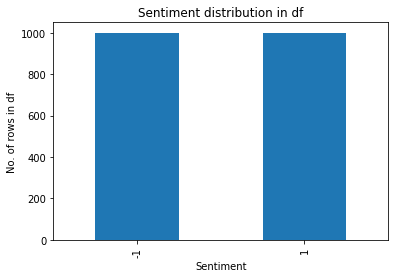

In [6]:
# Function to map stars to sentiment
def map_sentiment(sentiment):
    if sentiment == 'NEG':
        return -1
    else:
        return 1
# Mapping stars to sentiment into three categories
top_data_df['Sentiment_value'] = [map_sentiment(x) for x in top_data_df['Sentiment']]
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(top_data_df['Sentiment_value']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()




## Selecting equal number of positive and negative reviews for training:


In [7]:
# Function to retrieve top few number of each category
def get_top_data(top_n):
    top_data_df_positive = top_data_df[top_data_df['Sentiment_value'] == 1].head(top_n)
    top_data_df_negative = top_data_df[top_data_df['Sentiment_value'] == -1].head(top_n)
    top_data_df_small = pd.concat([top_data_df_positive, top_data_df_negative])
    return top_data_df_small

In [8]:
top_data_df_small = get_top_data(999)
print("After segregating and taking equal number of rows for each sentiment:")
print(top_data_df_small['Sentiment_value'].value_counts())

After segregating and taking equal number of rows for each sentiment:
 1    999
-1    999
Name: Sentiment_value, dtype: int64


In [9]:
top_data_df_small.head(10)

,Unnamed: 0,URL,Text,Sentiment,Sentiment_value
0,0,http://www.imdb.com/title/tt0210075/usercomments,Girlfight follows a project dwelling New York ...,POS,1
1,1,http://www.imdb.com/title/tt0337640/usercomments,Hollywood North is an euphemism from the movie...,POS,1
2,2,http://www.imdb.com/title/tt0303549/usercomments,That '70s Show is definitely the funniest show...,POS,1
3,3,http://www.imdb.com/title/tt0716825/usercomments,"9/10- 30 minutes of pure holiday terror. Okay,...",POS,1
4,4,http://www.imdb.com/title/tt0182225/usercomments,"A series of random, seemingly insignificant th...",POS,1
5,5,http://www.imdb.com/title/tt0347779/usercomments,A very good adaptation of the novel by amrita ...,POS,1
6,6,http://www.imdb.com/title/tt0095655/usercomments,"Ah, Moonwalker, I'm a huge Michael Jackson fan...",POS,1
7,7,http://www.imdb.com/title/tt0298131/usercomments,Although the beginning of the movie in New Yor...,POS,1
8,8,http://www.imdb.com/title/tt0088915/usercomments,"As many reviewers here have noted, the film ve...",POS,1
9,9,http://www.imdb.com/title/tt0828154/usercomments,"Bear in mind, any film (let alone documentary)...",POS,1


# Dataset cleaning and analysing

In [10]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

In [11]:
def remove_stopwords(data):
  data['review without stopwords'] = data['Text'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
  return data

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
    
data_without_stopwords = remove_stopwords(data)
data_without_stopwords['clean_review']= data_without_stopwords['review without stopwords'].apply(lambda cw : remove_tags(cw))
data_without_stopwords['clean_review'] = data_without_stopwords['clean_review'].str.replace('[{}]'.format(string.punctuation), ' ')

In [12]:
data_without_stopwords.head()

,URL,Text,Sentiment,review without stopwords,clean_review
0,http://www.imdb.com/title/tt0210075/usercomments,girlfight follows a project dwelling new york ...,POS,girlfight follows project dwelling new york hi...,girlfight follows project dwelling new york hi...
1,http://www.imdb.com/title/tt0337640/usercomments,hollywood north is an euphemism from the movie...,POS,hollywood north euphemism movie industry went ...,hollywood north euphemism movie industry went ...
2,http://www.imdb.com/title/tt0303549/usercomments,that '70s show is definitely the funniest show...,POS,'70s show definitely funniest show currently t...,70s show definitely funniest show currently t...
3,http://www.imdb.com/title/tt0716825/usercomments,"9/10- 30 minutes of pure holiday terror. okay,...",POS,"9/10- 30 minutes pure holiday terror. okay, no...",9 10 30 minutes pure holiday terror okay no...
4,http://www.imdb.com/title/tt0182225/usercomments,"a series of random, seemingly insignificant th...",POS,"series random, seemingly insignificant thefts ...",series random seemingly insignificant thefts ...


In [13]:
reviews_list = []
for i in range(len(data_without_stopwords['clean_review'])):
  reviews_list.append(data_without_stopwords['clean_review'][i])
 
sentiment = data_without_stopwords['Sentiment']

In [14]:
y = np.array(list(map(lambda x: 1 if x=="POS" else 0, sentiment)))

### Data split

In [15]:
X_train, X_test,Y_train, Y_test = train_test_split(reviews_list, y, test_size=0.2, random_state = 45)

### Data Tokenization

In [16]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index
#type(words_to_index)

# Making Global Vector Map

In [17]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
  return word_to_vec_map

Download and mount the file glove.6B.50d.txt

https://www.kaggle.com/watts2/glove6b50dtxt
 
https://nlp.stanford.edu/projects/glove/


In [18]:
# !unzip '/content/drive/My Drive/dataset/glove.6B.50d.txt.zip' -d '/content/drive/My Drive/dataset/'

In [19]:
word_to_vec_map = read_glove_vector('/content/drive/My Drive/dataset/glove.6B.50d.txt')
maxLen = 150

In [20]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index - 1, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

### Defining Model

In [21]:
X_train_indices = tokenizer.texts_to_sequences(X_train)
X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')

In [22]:
X_test_indices = tokenizer.texts_to_sequences(X_test)
X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

In [23]:
## Helper Functions

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
import pickle

def generate_report(pred_list, custom_model, model_name,y_test):
  print(f'Confusion Matrix:\n{confusion_matrix(y_test,pred_list)}')
  print(f'\nClassification Report:\n{classification_report(y_test,pred_list)}')
  acc = accuracy_score(y_test, pred_list) * 100
  print(f'Accuracy: {acc}%')
  prec = precision_score(y_test, pred_list, average='macro') * 100
  print(f'Precision: {prec}%')
  rec = recall_score(y_test, pred_list, average='macro') * 100
  print(f'Recall: {rec}%')
  pickle.dump(custom_model, open(model_name + '.sav', 'wb'))
  print(model_name + ' trained Model Saved')
  return acc, prec, rec


## Bernoulli Naïve Bayes (BNB)


In [24]:
from sklearn.naive_bayes import BernoulliNB
classifier = BernoulliNB()
classifier.fit(X_train_indices,Y_train)
BNBpred=classifier.predict(X_test_indices)

In [25]:
bnb_metrics = [None, None, None]
bnb_metrics[0], bnb_metrics[1], bnb_metrics[2] = generate_report(BNBpred, classifier, 'BernoulliNB_model',Y_test)

Confusion Matrix:
[[ 96  91]
 [109 104]]

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.51      0.49       187
           1       0.53      0.49      0.51       213

    accuracy                           0.50       400
   macro avg       0.50      0.50      0.50       400
weighted avg       0.50      0.50      0.50       400

Accuracy: 50.0%
Precision: 50.081300813008134%
Recall: 50.08159473776706%
BernoulliNB_model trained Model Saved



## Multinomial Naïve Bayes (MNB)


In [26]:
from sklearn.naive_bayes import MultinomialNB

In [27]:
classifier = MultinomialNB()

#train the model
classifier.fit(X_train_indices,Y_train)
MNBpred=classifier.predict(X_test_indices)

In [28]:
mnb_metrics = [None, None, None]
mnb_metrics[0], mnb_metrics[1], mnb_metrics[2] = generate_report(MNBpred, classifier, 'MultinomialNB_model',Y_test)



Confusion Matrix:
[[ 83 104]
 [ 92 121]]

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.44      0.46       187
           1       0.54      0.57      0.55       213

    accuracy                           0.51       400
   macro avg       0.51      0.51      0.51       400
weighted avg       0.51      0.51      0.51       400

Accuracy: 51.0%
Precision: 50.60317460317461%
Recall: 50.59626923752856%
MultinomialNB_model trained Model Saved



## Maximum Entropy (ME)


In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
classifier = LogisticRegression()

# Train the Model
classifier.fit(X_train_indices,Y_train)   
LRpred = classifier.predict(X_test_indices)

lr_metrics = [None, None, None]
lr_metrics[0], lr_metrics[1], lr_metrics[2] = generate_report(LRpred, classifier, 'LinearRegression_model',Y_test)



Confusion Matrix:
[[ 94  93]
 [ 96 117]]

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.50      0.50       187
           1       0.56      0.55      0.55       213

    accuracy                           0.53       400
   macro avg       0.53      0.53      0.53       400
weighted avg       0.53      0.53      0.53       400

Accuracy: 52.75%
Precision: 52.59398496240601%
Recall: 52.59847857196655%
LinearRegression_model trained Model Saved



## Decision Tree (DE)


In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


In [32]:
dt_clf = DecisionTreeClassifier()

# Train the Model
dt_clf.fit(X_train_indices,Y_train)   
dt_pred = dt_clf.predict(X_test_indices)

dt_metrics = [None, None, None]
dt_metrics[0], dt_metrics[1], dt_metrics[2] = generate_report(dt_pred, dt_clf, 'DecisionTree_model',Y_test)



Confusion Matrix:
[[ 94  93]
 [ 97 116]]

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.50      0.50       187
           1       0.56      0.54      0.55       213

    accuracy                           0.53       400
   macro avg       0.52      0.52      0.52       400
weighted avg       0.53      0.53      0.53       400

Accuracy: 52.5%
Precision: 52.35852601518074%
Recall: 52.36373678792901%
DecisionTree_model trained Model Saved


## Support Vector Machine (SVM)


In [33]:
from sklearn.svm import SVC
from sklearn import svm


In [34]:
%%time
SVMclassifier = svm.SVC(kernel='rbf')
SVMclassifier.fit(X_train_indices,Y_train)
SVMpred = SVMclassifier.predict(X_test_indices)

CPU times: user 831 ms, sys: 17.2 ms, total: 848 ms
Wall time: 856 ms


In [35]:
svm_metrics = [None, None, None]
svm_metrics[0], svm_metrics[1], svm_metrics[2] = generate_report(SVMpred, SVMclassifier, 'SVM_model',Y_test)

Confusion Matrix:
[[123  64]
 [113 100]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.66      0.58       187
           1       0.61      0.47      0.53       213

    accuracy                           0.56       400
   macro avg       0.57      0.56      0.56       400
weighted avg       0.57      0.56      0.55       400

Accuracy: 55.75%
Precision: 56.54712691194709%
Recall: 56.36187893851523%
SVM_model trained Model Saved



## Results comparision plots and tables


In [36]:
from tabulate import tabulate
table = [['Model Name', 'Accuracy', 'Precision', 'Recall'], 
         ['Multinomial Naïve Bayes', mnb_metrics[0], mnb_metrics[1], mnb_metrics[2]], 
         ['Bernoulli Naïve Bayes', bnb_metrics[0], bnb_metrics[1], bnb_metrics[2]],
         ['Support Vector Machine', svm_metrics[0], svm_metrics[1], svm_metrics[2]],
         ['Maximum Entropy', lr_metrics[0], lr_metrics[1], lr_metrics[2]],
         ['Decision Tree', dt_metrics[0], dt_metrics[1], dt_metrics[2]]]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════════════════╤════════════╤═════════════╤══════════╕
│ Model Name              │   Accuracy │   Precision │   Recall │
╞═════════════════════════╪════════════╪═════════════╪══════════╡
│ Multinomial Naïve Bayes │      51    │     50.6032 │  50.5963 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Bernoulli Naïve Bayes   │      50    │     50.0813 │  50.0816 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Support Vector Machine  │      55.75 │     56.5471 │  56.3619 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Maximum Entropy         │      52.75 │     52.594  │  52.5985 │
├─────────────────────────┼────────────┼─────────────┼──────────┤
│ Decision Tree           │      52.5  │     52.3585 │  52.3637 │
╘═════════════════════════╧════════════╧═════════════╧══════════╛


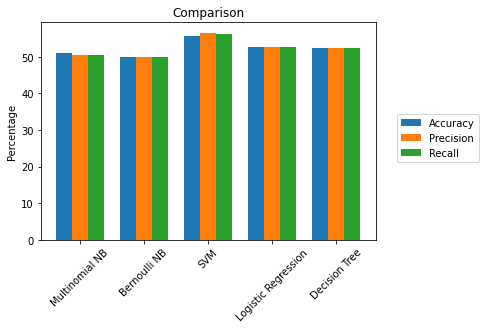

In [37]:
  
N = 5
ind = np.arange(N) 
width = 0.25
  
acc = [mnb_metrics[0], bnb_metrics[0], svm_metrics[0], lr_metrics[0], dt_metrics[0]]
bar1 = plt.bar(ind, acc, width)
  
prec = [mnb_metrics[1], bnb_metrics[1], svm_metrics[1], lr_metrics[1], dt_metrics[1]]
bar2 = plt.bar(ind+width, prec, width)
  
recall = [mnb_metrics[2], bnb_metrics[2], svm_metrics[2], lr_metrics[2], dt_metrics[2]]
bar3 = plt.bar(ind+width*2, recall, width)
  
# plt.xlabel("Dates")
plt.ylabel("Percentage")
plt.title("Comparison")
  
plt.xticks(ind+width,['Multinomial NB','Bernoulli NB','SVM','Logistic Regression', 'Decision Tree'])
plt.xticks(rotation = 45)
plt.legend( (bar1, bar2, bar3), ('Accuracy', 'Precision', 'Recall'), bbox_to_anchor = (1.05, 0.6))
plt.show()



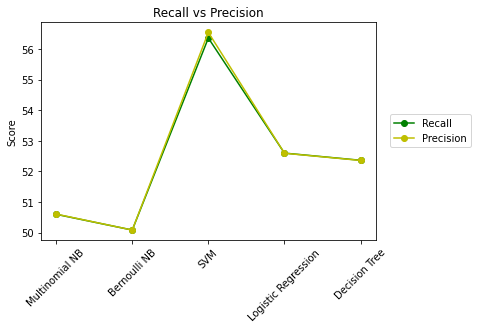

In [38]:
import matplotlib.pyplot as plt
models = ['Multinomial NB','Bernoulli NB','SVM','Logistic Regression', 'Decision Tree']
recall = [mnb_metrics[2], bnb_metrics[2], svm_metrics[2], lr_metrics[2], dt_metrics[2]]
precision = [mnb_metrics[1], bnb_metrics[1], svm_metrics[1], lr_metrics[1], dt_metrics[1]]
line_chart1 = plt.plot(models, recall, 'o-g')
line_chart2 = plt.plot(models, precision, 'o-y')
plt.title('Recall vs Precision')
plt.ylabel('Score')
plt.xticks(rotation = 45)
plt.legend(['Recall', 'Precision'], bbox_to_anchor = (1.3, 0.6))
plt.show()